In [1]:
import RINEX
import pos
import math
import time
import datetime
import pynmea2
from pyproj import transform
import pyproj
import serial
import pandas as pd
import numpy as np
import nvector as nv
from geopy.distance import geodesic, great_circle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.set_option('display.max_rows', None)

/home/gustavo/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/gustavo/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
file_path = "../../DATA/EXP1/BASE/CONVBIN/rover_201911091804.obs"
file_path_nav = "../../DATA/EXP1/BASE/CONVBIN/rover_201911091804.nav"
file_path_sp3 = "../../DATA/Ephemerides/2078/igu20786_12.sp3"
fileBase = "../../DATA/EXP1/BASE/RNXRTKP/sol1_201911091804.pos"
file_NMEA = '../../DATA/EXP1/IOT/logfile.txt'

In [3]:
def read2df(filename):
    iot_data = {'time':[], 'latitude':[], 'latitude direction':[], 'longitude':[], 'longitude direction':[], 'quality':[], 'in use':[],'PRN in use':[], 'antenna alt':[], #GGA
            # GLL
            'PDOP':[], 'HDOP':[], 'VDOP':[], #GSA
            #RMC
            'speed kmh':[], #VTG
            'date':[] #ZDA
            }

    sat_data = { 'time':[], #GGA
            'PRN':[], #GSA
            'elevation':[], 'azimuth':[], 'SNR':[] # GSV
            }

    iot_df = pd.DataFrame(iot_data)
    sat_df = pd.DataFrame(sat_data)

    iot_df['latitude direction'] = iot_df['latitude direction'].astype('str')
    iot_df['longitude direction'] = iot_df['longitude direction'].astype('str')
    iot_df['date'] = iot_df['date'].astype('str')
    iot_df['PRN in use'] = iot_df['PRN in use'].astype(object)


    f = open(filename)
    reader = pynmea2.NMEAStreamReader(f)

    #time - update on the go
    i=0
    while 1:
        try:
            for msg in reader.next():

                msg_type = msg.sentence_type

                if msg_type == 'GGA':
                    time = msg.timestamp
                    if time not in iot_df['time'].values:
                        iot_df = iot_df.append({'time':time}, ignore_index=True)
                    iot_time_idx = iot_df[iot_df['time'] == time].index.values.astype(int)[0]

                    iot_df.at[iot_time_idx, 'latitude'] = -(float(str(msg.lat)[:2]) + float(str(float(str(msg.lat)[2:])/60)))
                    iot_df.at[iot_time_idx, 'latitude direction']=msg.lat_dir
                    iot_df.at[iot_time_idx, 'longitude']= -(float(str(msg.lon)[:3]) + float(str(float(str(msg.lon)[3:])/60)))
                    iot_df.at[iot_time_idx, 'longitude direction']=msg.lon_dir
                    iot_df.at[iot_time_idx, 'quality']=msg.gps_qual
                    iot_df.at[iot_time_idx, 'in use']=msg.num_sats
                    iot_df.at[iot_time_idx, 'antenna alt']=msg.altitude


                elif msg_type == 'GLL':
                    pass
                    #print('gll')
                elif msg_type == 'GSA':
                    iot_df.at[iot_time_idx, 'PDOP']=msg.pdop
                    iot_df.at[iot_time_idx, 'HDOP']=msg.hdop
                    iot_df.at[iot_time_idx, 'VDOP']=msg.vdop

                    sat_list = []

                    if(msg.sv_id01):
                        sat_list.append(int(msg.sv_id01))
                    if(msg.sv_id02):
                        sat_list.append(int(msg.sv_id02))
                    if(msg.sv_id03):
                        sat_list.append(int(msg.sv_id03))
                    if(msg.sv_id04):
                        sat_list.append(int(msg.sv_id04))
                    if(msg.sv_id05):
                        sat_list.append(int(msg.sv_id05))
                    if(msg.sv_id06):
                        sat_list.append(int(msg.sv_id06))
                    if(msg.sv_id07):
                        sat_list.append(int(msg.sv_id07))
                    if(msg.sv_id08):
                        sat_list.append(int(msg.sv_id08))
                    if(msg.sv_id09):
                        sat_list.append(int(msg.sv_id09))
                    if(msg.sv_id10):
                        sat_list.append(int(msg.sv_id10))
                    if(msg.sv_id11):
                        sat_list.append(int(msg.sv_id11))
                    if(msg.sv_id12):
                        sat_list.append(int(msg.sv_id12))

                    iot_df.at[iot_time_idx, 'PRN in use'] = sat_list


                elif msg_type == 'GSV':

                    if msg.sv_prn_num_1:
                        sat_df = sat_df.append({'time':time, 'PRN': msg.sv_prn_num_1, 'elevation':msg.elevation_deg_1, 'azimuth':msg.azimuth_1, 'SNR':msg.snr_1}, ignore_index=True)
                    if msg.sv_prn_num_2:
                        sat_df = sat_df.append({'time':time, 'PRN': msg.sv_prn_num_2, 'elevation':msg.elevation_deg_2, 'azimuth':msg.azimuth_2, 'SNR':msg.snr_2}, ignore_index=True)
                    if msg.sv_prn_num_3:
                        sat_df = sat_df.append({'time':time, 'PRN': msg.sv_prn_num_3, 'elevation':msg.elevation_deg_3, 'azimuth':msg.azimuth_3, 'SNR':msg.snr_3}, ignore_index=True)
                    if msg.sv_prn_num_4:
                        sat_df = sat_df.append({'time':time, 'PRN': msg.sv_prn_num_4, 'elevation':msg.elevation_deg_4, 'azimuth':msg.azimuth_4, 'SNR':msg.snr_4}, ignore_index=True)

                    pass
                    #print('gsv')
                elif msg_type == 'RMC':
                    pass
                    #print('rmc')
                elif msg_type == 'VTG':
                    iot_df.at[iot_time_idx, 'speed kmh']=msg.spd_over_grnd_kmph
                    #print('vtg')
                elif msg_type == 'ZDA':
                    time = msg.timestamp
                    if time not in iot_df['time'].values:
                        iot_df = iot_df.append({'time':time}, ignore_index=True)
                    iot_time_idx = iot_df[iot_df['time'] == time].index.values.astype(int)[0]

                    iot_df.at[iot_time_idx, 'date']=str(msg.day)+'/'+str(msg.month)+'/'+str(msg.year)
                    #print('zda')
                elif msg_type == 'TXT':
                    pass
                    #print('txt')
                else:
                    pass
                    #print(msg_type)

            i += 1
        except:
            break
    f.close()
    
    iot_df = iot_df.set_index('time')
    sat_df = sat_df.set_index('time','PRN')
    sat_df.reset_index(inplace=True)
    sat_df.set_index(['time', 'PRN'], inplace = True)
    sat_df.sort_index(inplace = True)
    iot_df.drop(iot_df.tail(1).index,inplace=True)
    return iot_df, sat_df

def gps_to_ecef_custom(lat, lon, alt):
    rad_lat = lat * (math.pi / 180.0)
    rad_lon = lon * (math.pi / 180.0)

    a = 6378137.0
    finv = 298.257223563
    f = 1 / finv
    e2 = 1 - (1 - f) * (1 - f)
    v = a / math.sqrt(1 - e2 * math.sin(rad_lat) * math.sin(rad_lat))

    x = (v + alt) * math.cos(rad_lat) * math.cos(rad_lon)
    y = (v + alt) * math.cos(rad_lat) * math.sin(rad_lon)
    z = (v * (1 - e2) + alt) * math.sin(rad_lat)

    return x, y, z

def pos_file(fileBase):
    data = pd.read_csv(fileBase, sep="\s+", skiprows=9)
    data.columns = ['GPS Week', 'GPST', 'latitude(deg)', 'longitude(deg)', 'height(m)', 'Q', 'ns','sdn(m)', 'sde(m)', 'sdu(m)',
                    'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)','ratio']
    return data

In [4]:
obs_df, nav_df, sp3_df = RINEX.obtain_data(file_path, file_path_nav, file_path_sp3)

pos_df = pos_file(fileBase)

iot_df, sat_df = read2df(file_NMEA)

In [5]:
x_iot = []
y_iot = []
z_iot = []
xi = 0.
yi = 0.
zi = 0.
for(lat, lon, alt) in list(zip(iot_df['latitude'], iot_df['longitude'], iot_df['antenna alt'])):
    xi, yi, zi = gps_to_ecef_custom(lat, lon, alt)
    x_iot.append(xi)
    y_iot.append(yi)
    z_iot.append(zi)
iot_df['x(m)'] = x_iot
iot_df['y(m)'] = y_iot
iot_df['z(m)'] = z_iot

In [6]:
pos_df.head()

,GPS Week,GPST,latitude(deg),longitude(deg),height(m),Q,ns,sdn(m),sde(m),sdu(m),sdne(m),sdeu(m),sdun(m),age(s),ratio
0,2078,583499.0,-15.765921,-47.872176,1054.7010,5,12,3.4873,3.9729,9.6846,1.5830,-2.1848,-0.6321,0.0,0.0
1,2078,583500.0,-15.765922,-47.872178,1054.1277,5,12,3.4872,3.9728,9.6832,1.5830,-2.1830,-0.6332,0.0,0.0
2,2078,583501.0,-15.765924,-47.872177,1054.6422,5,12,3.4872,3.9727,9.6819,1.5829,-2.1811,-0.6343,0.0,0.0
3,2078,583502.0,-15.765926,-47.872178,1054.6129,5,12,3.4871,3.9726,9.6805,1.5829,-2.1793,-0.6354,0.0,0.0
4,2078,583503.0,-15.765927,-47.872180,1054.4976,5,12,3.4871,3.9725,9.6792,1.5829,-2.1774,-0.6366,0.0,0.0


In [7]:
iot_df.head()

,latitude,latitude direction,longitude,longitude direction,quality,in use,PRN in use,antenna alt,PDOP,HDOP,VDOP,speed kmh,date,x(m),y(m),z(m)
time,,,,,,,,,,,,,,,,
18:19:33,-15.768993,S,-47.870730,W,6.0,5.0,"[5, 21, 12, 25, 24]",2.7,4.8,1.9,4.4,3.69,9/11/2019,4.118490e+06,-4.553345e+06,-1.722142e+06
18:19:34,-15.768905,S,-47.870770,W,6.0,5.0,"[5, 21, 12, 25, 24]",4.6,4.8,1.9,4.4,3.85,9/11/2019,4.118490e+06,-4.553351e+06,-1.722133e+06
18:19:35,-15.768897,S,-47.870745,W,1.0,5.0,"[5, 21, 12, 25, 24]",4.3,4.8,1.9,4.4,4.20,9/11/2019,4.118492e+06,-4.553349e+06,-1.722132e+06
18:19:36,-15.768845,S,-47.870695,W,1.0,5.0,"[5, 21, 12, 25, 24]",4.3,4.8,1.9,4.4,4.84,9/11/2019,4.118497e+06,-4.553347e+06,-1.722127e+06
18:19:37,-15.768782,S,-47.870637,W,1.0,5.0,"[5, 21, 12, 25, 24]",4.3,4.8,1.9,4.4,5.41,9/11/2019,4.118502e+06,-4.553344e+06,-1.722120e+06


In [8]:
sp3_df.reset_index(inplace=True)
sp3_df.set_index('time', inplace=True)
#sp3_df.drop(['index'], axis = 1, inplace=True)
sp3_df.head()

,ECEF,sv,position,clock
time,,,,
2019-11-08 12:00:00,x,G01,20010.934584,-190.315009
2019-11-08 12:15:00,x,G01,18712.731441,-190.326480
2019-11-08 12:30:00,x,G01,17150.836087,-190.337959
2019-11-08 12:45:00,x,G01,15348.804968,-190.349418
2019-11-08 13:00:00,x,G01,13337.501924,-190.361020


/home/gustavo/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


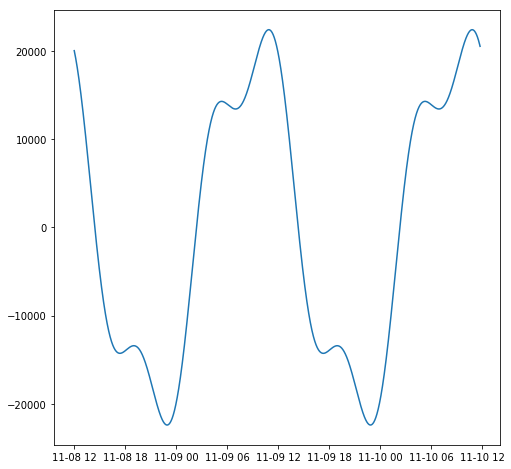

In [9]:
parte = sp3_df[sp3_df['sv'] == 'G01']
parte2 = parte[parte['ECEF'] == 'x']
parte2 = parte2.resample('S').mean()
parte2 = parte2.interpolate(method='quadratic', axis=0)
fig = plt.figure(figsize=(8,8)).gca()
fig.plot(parte2.index, parte2['position'])
plt.show()

In [10]:
init, end = '2019-11-09 ' + str(iot_df.index[0]), '2019-11-09 ' + str(iot_df.index[len(iot_df)-1])
init = pd.to_datetime(init)
end = pd.to_datetime(end)
print(init, end)

2019-11-09 18:19:33 2019-11-09 18:47:05


In [11]:
parte2 = parte2[parte2.index.get_level_values('time')>=init]
parte2 = parte2[parte2.index.get_level_values('time')<=end]
parte2.tail()

,position,clock
time,,
2019-11-09 18:47:01,-13424.934064,-191.729615
2019-11-09 18:47:02,-13424.864219,-191.729628
2019-11-09 18:47:03,-13424.794484,-191.729641
2019-11-09 18:47:04,-13424.724861,-191.729653
2019-11-09 18:47:05,-13424.655349,-191.729666


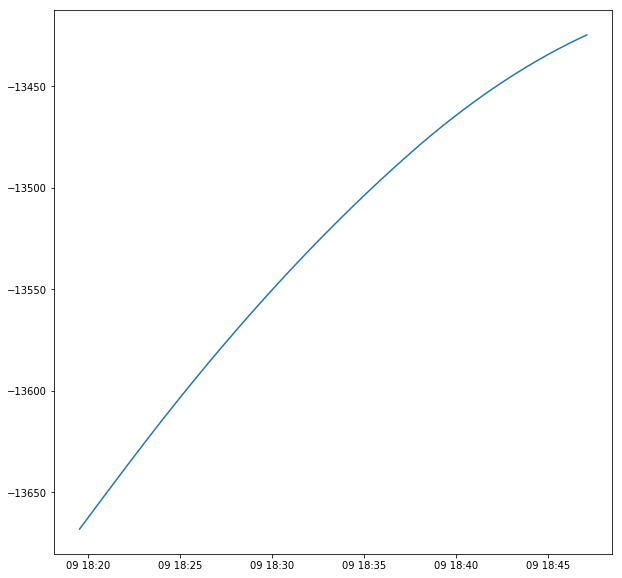

In [12]:
fig = plt.figure(figsize=(10,10)).gca()
fig.plot(parte2.index, parte2['position'])

In [13]:
list(set(sp3_df['sv'].values))
sorted(list(set(sp3_df['ECEF'].values)))

['x', 'y', 'z']

In [14]:
final_sat = pd.DataFrame()
for i in list(set(sp3_df['sv'].values)):
    for j in sorted(list(set(sp3_df['ECEF'].values))):
        parte = sp3_df[sp3_df['sv']  == i]
        parte2 = parte[parte['ECEF'] == j]
        parte2 = parte2.resample('S').mean()
        
        parte2['sv']   = [i] * len(parte2)
        parte2['ECEF'] = [j] * len(parte2)
        
        parte2 = parte2.interpolate('quadratic')
        
        parte2 = parte2[parte2.index.get_level_values('time')>=init]
        parte2 = parte2[parte2.index.get_level_values('time')<=end]
        
        #parte2 = parte2.reset_index().set_index(["time", "ECEF", "sv"])
        final_sat = pd.concat([final_sat, parte2], axis=0)
final_sat.head()

,position,clock,sv,ECEF
time,,,,
2019-11-09 18:19:33,-11459.107079,-156.517979,G23,x
2019-11-09 18:19:34,-11461.205278,-156.517977,G23,x
2019-11-09 18:19:35,-11463.303568,-156.517975,G23,x
2019-11-09 18:19:36,-11465.401949,-156.517972,G23,x
2019-11-09 18:19:37,-11467.500420,-156.517970,G23,x


In [15]:
final_sat = final_sat.reset_index().set_index(["time", "sv", "ECEF"])

In [16]:
final_sat.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 153729 entries, (2019-11-09 18:19:33, G23, x) to (2019-11-09 18:47:05, G22, z)
Data columns (total 2 columns):
position    153729 non-null float64
clock       153729 non-null float64
dtypes: float64(2)
memory usage: 2.9+ MB


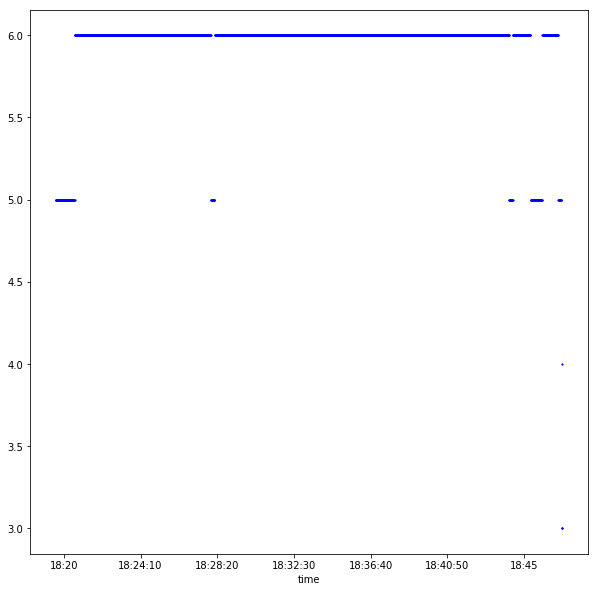

In [17]:
fig = plt.figure(figsize=(10,10)).gca()
for i, row in iot_df.iterrows():
    fig.scatter(i, len(row['PRN in use']), color='b', s=1.5)
plt.show()

In [18]:
go = time.time()
light = 299792458.0
data = {'time':[], 'sv':[], 'pseudorange(m)':[], 'sat_clock_delta(m)':[], 'X':[], 'Y':[], 'Z':[]}
rho = pd.DataFrame(data)
for i, row in iot_df.iterrows():
    x = row['x(m)']
    y = row['y(m)']
    z = row['z(m)']
    for j in range(len(row['PRN in use'])):
        if (row['PRN in use'][j] == 5):
            X = float(final_sat.xs((i, 'G0' + str(row['PRN in use'][j]), 'x'), level=[0,1,2])['position'])*1000
            Y = float(final_sat.xs((i, 'G0' + str(row['PRN in use'][j]), 'y'), level=[0,1,2])['position'])*1000
            Z = float(final_sat.xs((i, 'G0' + str(row['PRN in use'][j]), 'z'), level=[0,1,2])['position'])*1000
            clock = float(final_sat.xs((i, 'G0' + str(row['PRN in use'][j]), 'z'), level=[0,1,2])['clock'])
        else:
            X = float(final_sat.xs((i, 'G' + str(row['PRN in use'][j]), 'x'), level=[0,1,2])['position'])*1000
            Y = float(final_sat.xs((i, 'G' + str(row['PRN in use'][j]), 'y'), level=[0,1,2])['position'])*1000
            Z = float(final_sat.xs((i, 'G' + str(row['PRN in use'][j]), 'z'), level=[0,1,2])['position'])*1000
            clock = float(final_sat.xs((i, 'G' + str(row['PRN in use'][j]), 'z'), level=[0,1,2])['clock'])
        pseudorange = math.sqrt((X - x)**2 + (Y - y)**2 + (Z - z)**2)
        rho = rho.append({'time': i, 'sv': row['PRN in use'][j], 'pseudorange(m)': pseudorange, 
                          'sat_clock_delta(m)': clock*light/(10)**9, 'X': X, 'Y':Y, 'Z':Z}, ignore_index=True)
print(time.time() - go)
rho.set_index(['time', 'sv'], inplace=True)
rho.head()

104.42307257652283


pseudorange(m)  sat_clock_delta(m)             X             Y  \
time     sv                                                                     
18:19:33 5.0     2.237800e+07           -0.976292  2.492927e+07 -1.668847e+06   
         21.0    2.297393e+07          -26.602950  7.048508e+05 -2.639159e+07   
         12.0    2.096399e+07           55.538498  2.417895e+07 -9.557716e+06   
         25.0    2.088844e+07           -5.077107  1.302866e+07 -1.616729e+07   
         24.0    2.298457e+07           -1.390483  1.413360e+07 -1.571384e+07   

                          Z  
time     sv                  
18:19:33 5.0  -9.427062e+06  
         21.0  4.541978e+06  
         12.0 -5.189558e+06  
         25.0 -1.662355e+07  
         24.0  1.569714e+07

In [19]:
obs_df.reset_index(inplace=True)
obs_df['time'] = obs_df['time'].dt.round('1s')
obs_df.set_index(['time', 'sv'], inplace=True)
obs_df = obs_df[obs_df.index.get_level_values('time')>=init]
obs_df = obs_df[obs_df.index.get_level_values('time')<=end]
obs_df.head()

,,C1,L1
time,sv,,
2019-11-09 18:19:33,G02,2.392737e+07,1.257391e+08
2019-11-09 18:19:34,G02,2.392801e+07,1.257425e+08
2019-11-09 18:19:35,G02,2.392866e+07,1.257459e+08
2019-11-09 18:19:36,G02,2.392930e+07,1.257493e+08
2019-11-09 18:19:37,G02,2.392995e+07,1.257527e+08


In [20]:
obs_df = obs_df.sort_values('time')

In [21]:
go = time.time()
data = {'time':[], 'sv':[], 'error':[]}
err = pd.DataFrame(data)
for i, row in rho.iterrows():
    if int(i[1]) == 5:
        value = float(obs_df.xs([i[0], 'G0' + str(int(i[1]))])['C1'])
    else:
        value = float(obs_df.xs([i[0], 'G' + str(int(i[1]))])['C1'])
    err = err.append({'time': i[0], 'sv': i[1], 'error': (float(row['pseudorange(m)'])-value)/value*100}, ignore_index=True)
err.set_index('time', inplace=True)
print(time.time()-go)
err.head()

22.33611512184143


,sv,error
time,,
18:19:33,5.0,0.800815
18:19:33,21.0,0.666969
18:19:33,12.0,1.131099
18:19:33,25.0,0.838635
18:19:33,24.0,0.778579


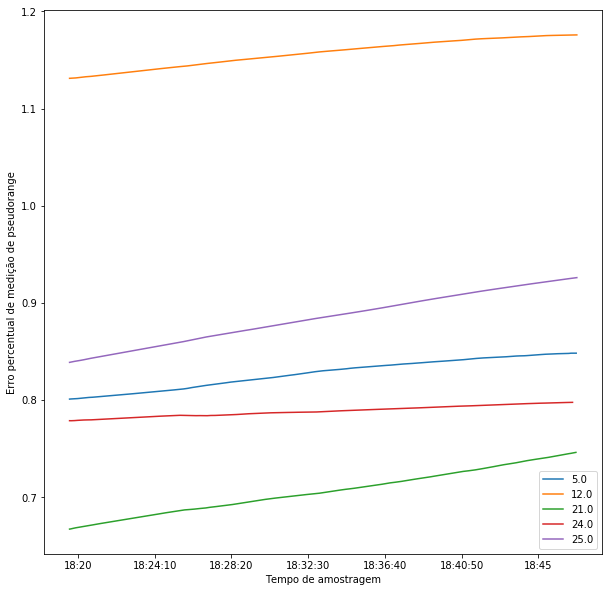

In [22]:
fig = plt.figure(figsize=(10,10)).gca()
lista = [5.0, 12.0, 21.0, 24.0, 25.0]
for i in lista:
    fig.plot(err[err['sv']==i]['error'])
plt.legend(lista)
plt.xlabel('Tempo de amostragem')
plt.ylabel('Erro percentual de medição de pseudorange')
plt.show()

In [23]:
## Pesquisado no arquivo IONEX TEC map - valor de VTEC para T=18:00:00, latitude -15.0 e longitude -45.0 e -50: 8 e 9
VTEC = 8.5
f1 = 1575.4
rho['IONEX'] = [40.3*VTEC*10**16/((f1)*10**6)**2] * len(rho)
rho['Ajustado_IONEX'] = rho['pseudorange(m)'] + rho['IONEX']
rho['Ajustado_IONEX+sat_clock'] = rho['Ajustado_IONEX'] - rho['sat_clock_delta(m)']
rho.head()

pseudorange(m)  sat_clock_delta(m)             X             Y  \
time     sv                                                                     
18:19:33 5.0     2.237800e+07           -0.976292  2.492927e+07 -1.668847e+06   
         21.0    2.297393e+07          -26.602950  7.048508e+05 -2.639159e+07   
         12.0    2.096399e+07           55.538498  2.417895e+07 -9.557716e+06   
         25.0    2.088844e+07           -5.077107  1.302866e+07 -1.616729e+07   
         24.0    2.298457e+07           -1.390483  1.413360e+07 -1.571384e+07   

                          Z     IONEX  Ajustado_IONEX  \
time     sv                                             
18:19:33 5.0  -9.427062e+06  1.380201    2.237800e+07   
         21.0  4.541978e+06  1.380201    2.297393e+07   
         12.0 -5.189558e+06  1.380201    2.096399e+07   
         25.0 -1.662355e+07  1.380201    2.088844e+07   
         24.0  1.569714e+07  1.380201    2.298457e+07   

               Ajustado_IONEX+sat_clock  
time     sv                              
18:19:33 5.0               2.237800e+07  
         21.0              2.297395e+07  
         12.0              2.096393e+07  
         25.0              2.088845e+07  
         24.0              2.298457e+07

In [24]:
#SITE ____EPOCH___ TROTOT STDDEV  TGNTOT STDDEV  TGETOT STDDEV
#BRAZ 19:313:66000 2179.2    1.7  -0.119  0.205   1.152  0.298
#BRAZ 19:313:66300 2178.1    1.6  -0.119  0.193   1.123  0.293
#BRAZ 19:313:66600 2177.8    1.7  -0.119  0.203   1.094  0.303
#BRAZ 19:313:66900 2178.2    1.7  -0.106  0.194   1.065  0.301
#BRAZ 19:313:67200 2178.3    1.8  -0.093  0.208   1.037  0.313
#BRAZ 19:313:67500 2178.5    1.8  -0.075  0.198   1.008  0.309 - TROTOT é o erro!!! Em mm
valores = [2179.2, 2178.1, 2177.8, 2178.2, 2178.3, 2178.5]
ZPD = sum(valores)/len(valores)
rho['ZPD'] = [ZPD/1000] * len(rho)
rho['Ajustado_FINAL'] = rho['Ajustado_IONEX+sat_clock'] + rho['ZPD']
rho.tail(10)

pseudorange(m)  sat_clock_delta(m)             X             Y  \
time     sv                                                                     
18:47:03 5.0     2.269624e+07           -0.976523  2.288079e+07 -3.516093e+05   
         12.0    2.127174e+07           55.536539  2.476715e+07 -9.332704e+06   
         25.0    2.038213e+07           -5.077334  1.598862e+07 -1.694514e+07   
         31.0    2.381809e+07           -0.623459 -8.040339e+06 -2.028516e+07   
18:47:04 12.0    2.127201e+07           55.536538  2.476719e+07 -9.332471e+06   
         25.0    2.038190e+07           -5.077334  1.599016e+07 -1.694560e+07   
         31.0    2.381780e+07           -0.623460 -8.039874e+06 -2.028701e+07   
18:47:05 12.0    2.127227e+07           55.536536  2.476724e+07 -9.332238e+06   
         25.0    2.038166e+07           -5.077334  1.599170e+07 -1.694605e+07   
         31.0    2.381751e+07           -0.623460 -8.039410e+06 -2.028887e+07   

                          Z     IONEX  Ajustado_IONEX  \
time     sv                                             
18:47:03 5.0  -1.378126e+07  1.380201    2.269625e+07   
         12.0  9.033071e+04  1.380201    2.127174e+07   
         25.0 -1.272055e+07  1.380201    2.038213e+07   
         31.0 -1.483552e+07  1.380201    2.381810e+07   
18:47:04 12.0  9.355850e+04  1.380201    2.127201e+07   
         25.0 -1.271794e+07  1.380201    2.038190e+07   
         31.0 -1.483319e+07  1.380201    2.381780e+07   
18:47:05 12.0  9.678630e+04  1.380201    2.127228e+07   
         25.0 -1.271533e+07  1.380201    2.038166e+07   
         31.0 -1.483085e+07  1.380201    2.381751e+07   

               Ajustado_IONEX+sat_clock      ZPD  Ajustado_FINAL  
time     sv                                                       
18:47:03 5.0               2.269625e+07  2.17835    2.269625e+07  
         12.0              2.127169e+07  2.17835    2.127169e+07  
         25.0              2.038214e+07  2.17835    2.038214e+07  
         31.0              2.381810e+07  2.17835    2.381810e+07  
18:47:04 12.0              2.127195e+07  2.17835    2.127196e+07  
         25.0              2.038190e+07  2.17835    2.038190e+07  
         31.0              2.381780e+07  2.17835    2.381781e+07  
18:47:05 12.0              2.127222e+07  2.17835    2.127222e+07  
         25.0              2.038167e+07  2.17835    2.038167e+07  
         31.0              2.381751e+07  2.17835    2.381751e+07

In [25]:
#Comparing
go = time.time()
data = {'time':[], 'sv':[], 'error':[]}
err = pd.DataFrame(data)
for i, row in rho.iterrows():
    if int(i[1]) == 5:
        value = obs_df.xs([i[0], 'G0' + str(int(i[1]))])['C1']
    else:
        value = obs_df.xs([i[0], 'G' + str(int(i[1]))])['C1']
    err = err.append({'time': i[0], 'sv': i[1], 'error': float(row['Ajustado_FINAL']-value)/value*100}, ignore_index=True)
err.set_index('time', inplace=True)
print(time.time()-go)
err.head()

21.817368268966675


,sv,error
time,,
18:19:33,5.0,0.800836
18:19:33,21.0,0.667101
18:19:33,12.0,1.130848
18:19:33,25.0,0.838677
18:19:33,24.0,0.778600


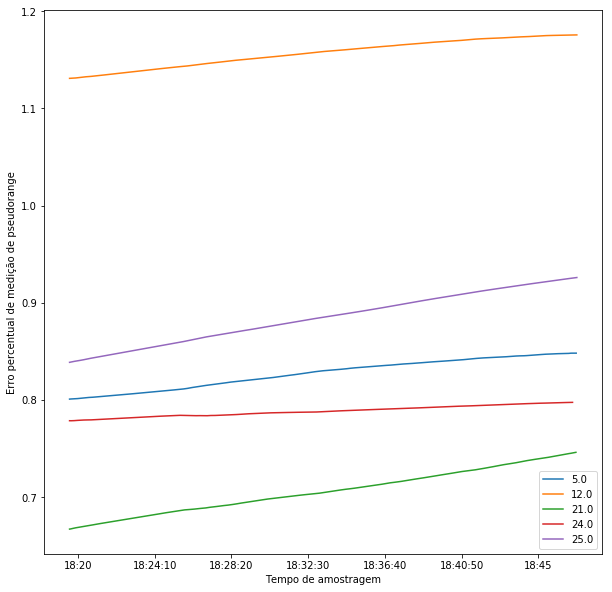

In [26]:
fig = plt.figure(figsize=(10,10)).gca()
lista = [5.0, 12.0, 21.0, 24.0, 25.0]
for i in lista:
    fig.plot(err[err['sv']==i]['error'])
plt.legend(lista)
plt.xlabel('Tempo de amostragem')
plt.ylabel('Erro percentual de medição de pseudorange')
plt.show()

In [27]:
rho['diff'] = (rho['pseudorange(m)']-rho['Ajustado_FINAL'])/rho['pseudorange(m)']

rho.head()

pseudorange(m)  sat_clock_delta(m)             X             Y  \
time     sv                                                                     
18:19:33 5.0     2.237800e+07           -0.976292  2.492927e+07 -1.668847e+06   
         21.0    2.297393e+07          -26.602950  7.048508e+05 -2.639159e+07   
         12.0    2.096399e+07           55.538498  2.417895e+07 -9.557716e+06   
         25.0    2.088844e+07           -5.077107  1.302866e+07 -1.616729e+07   
         24.0    2.298457e+07           -1.390483  1.413360e+07 -1.571384e+07   

                          Z     IONEX  Ajustado_IONEX  \
time     sv                                             
18:19:33 5.0  -9.427062e+06  1.380201    2.237800e+07   
         21.0  4.541978e+06  1.380201    2.297393e+07   
         12.0 -5.189558e+06  1.380201    2.096399e+07   
         25.0 -1.662355e+07  1.380201    2.088844e+07   
         24.0  1.569714e+07  1.380201    2.298457e+07   

               Ajustado_IONEX+sat_clock      ZPD  Ajustado_FINAL          diff  
time     sv                                                                     
18:19:33 5.0               2.237800e+07  2.17835    2.237800e+07 -2.026474e-07  
         21.0              2.297395e+07  2.17835    2.297396e+07 -1.312858e-06  
         12.0              2.096393e+07  2.17835    2.096394e+07  2.479488e-06  
         25.0              2.088845e+07  2.17835    2.088845e+07 -4.134181e-07  
         24.0              2.298457e+07  2.17835    2.298457e+07 -2.153199e-07

In [28]:
data = {'time':[], 'LS_sol':[], 'res':[], 'rank':[], 'val_matrix':[]}
result_df = pd.DataFrame(data)

size = 0
for i, row in rho.iterrows():
    
    total = len(iot_df.xs(i[0])['PRN in use'])
    
    if total<5:
        if size==total-1:
            print('Número menor que o possível para estimação (' + str(total) + '), utilizando valor anterior...')
            result_df = result_df.append({'time':i[0], 'LS_sol':x, 'res':residuals, 'rank':rank, 'val_matrix':s}, ignore_index=True)
            size = -1
        
    elif total==5:
    
        if size==0:
            X0 = row['X']
            Y0 = row['Y']
            Z0 = row['Z']
            ro0 = row['Ajustado_FINAL']

        elif size==1:
            X1 = row['X']
            Y1 = row['Y']
            Z1 = row['Z']
            ro1 = row['Ajustado_FINAL']

        elif size==2:
            X2 = row['X']
            Y2 = row['Y']
            Z2 = row['Z']
            ro2 = row['Ajustado_FINAL']

        elif size==3:
            X3 = row['X']
            Y3 = row['Y']
            Z3 = row['Z']
            ro3 = row['Ajustado_FINAL']

        elif size==4:
            X4 = row['X']
            Y4 = row['Y']
            Z4 = row['Z']
            ro4 = row['Ajustado_FINAL']

            #, light*(ro0 - ro1)
            A = np.array([[2*(X1 - X0), 2*(Y1 - Y0), 2*(Z1 - Z0), 2*light*(ro0 - ro1)],
                         [2*(X2 - X0), 2*(Y2 - Y0), 2*(Z2 - Z0), 2*light*(ro0 - ro2)],
                         [2*(X3 - X0), 2*(Y3 - Y0), 2*(Z3 - Z0), 2*light*(ro0 - ro3)],
                         [2*(X4 - X0), 2*(Y4 - Y0), 2*(Z4 - Z0), 2*light*(ro0 - ro4)]])

            b = np.array([ro0**2 - ro1**2 + X1**2 + Y1**2 + Z1**2 - X0**2 - Y0**2 - Z0**2, 
                         ro0**2 - ro2**2 + X2**2 + Y2**2 + Z2**2 - X0**2 - Y0**2 - Z0**2, 
                         ro0**2 - ro3**2 + X3**2 + Y3**2 + Z3**2 - X0**2 - Y0**2 - Z0**2, 
                         ro0**2 - ro4**2 + X4**2 + Y4**2 + Z4**2 - X0**2 - Y0**2 - Z0**2])

            x, residuals, rank, s = np.linalg.lstsq(A,b)

            result_df = result_df.append({'time':i[0], 'LS_sol':x, 'res':residuals, 'rank':rank, 'val_matrix':s}, ignore_index=True)

            size = -1
        
    elif total==6:
            
        if size==0:
            X0 = row['X']
            Y0 = row['Y']
            Z0 = row['Z']
            ro0 = row['Ajustado_FINAL']

        elif size==1:
            X1 = row['X']
            Y1 = row['Y']
            Z1 = row['Z']
            ro1 = row['Ajustado_FINAL']

        elif size==2:
            X2 = row['X']
            Y2 = row['Y']
            Z2 = row['Z']
            ro2 = row['Ajustado_FINAL']

        elif size==3:
            X3 = row['X']
            Y3 = row['Y']
            Z3 = row['Z']
            ro3 = row['pseudorange(m)']

        elif size==4:
            X4 = row['X']
            Y4 = row['Y']
            Z4 = row['Z']
            ro4 = row['Ajustado_FINAL']
            
        elif size==5:
            X5 = row['X']
            Y5 = row['Y']
            Z5 = row['Z']
            ro5 = row['Ajustado_FINAL']
            #, light*(ro0 - ro1)
            
            A = np.array([[X1 - X0, Y1 - Y0, Z1 - Z0, light*(ro0 - ro1)],
                         [X2 - X0, Y2 - Y0, Z2 - Z0, light*(ro0 - ro2)],
                         [X3 - X0, Y3 - Y0, Z3 - Z0, light*(ro0 - ro3)],
                         [X4 - X0, Y4 - Y0, Z4 - Z0, light*(ro0 - ro4)], 
                         [X5 - X0, Y5 - Y0, Z5 - Z0, light*(ro0 - ro5)]])

            b = np.array([(ro0**2 - ro1**2 + X1**2 + Y1**2 + Z1**2 - X0**2 - Y0**2 - Z0**2)/2, 
                         (ro0**2 - ro2**2 + X2**2 + Y2**2 + Z2**2 - X0**2 - Y0**2 - Z0**2)/2, 
                         (ro0**2 - ro3**2 + X3**2 + Y3**2 + Z3**2 - X0**2 - Y0**2 - Z0**2)/2, 
                         (ro0**2 - ro4**2 + X4**2 + Y4**2 + Z4**2 - X0**2 - Y0**2 - Z0**2)/2, 
                         (ro0**2 - ro5**2 + X5**2 + Y5**2 + Z5**2 - X0**2 - Y0**2 - Z0**2)/2])

            x, residuals, rank, s = np.linalg.lstsq(A,b)

            result_df = result_df.append({'time':i[0], 'LS_sol':x, 'res':residuals, 'rank':rank, 'val_matrix':s}, ignore_index=True)

            size = -1
        
    size = size + 1

/home/gustavo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/gustavo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Número menor que o possível para estimação (4), utilizando valor anterior...
Número menor que o possível para estimação (3), utilizando valor anterior...
Número menor que o possível para estimação (3), utilizando valor anterior...


In [29]:
result_df.set_index('time', inplace=True)

In [30]:
result_df['LS_sol'][0]

array([ 4.11889232e+06, -4.55372997e+06, -1.72220691e+06, -3.00300850e-06])

In [31]:
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

data = {'time':[], 'latitude':[], 'longitude':[], 'height':[]}
final = pd.DataFrame(data)
for i, row in result_df.iterrows():
    x = row['LS_sol'][0]
    y = row['LS_sol'][1]
    z = row['LS_sol'][2]
    lon, lat, alt = transform(ecef, lla, x, y, z, radians=False)
    
    final = final.append({'time':i, 'latitude':lat, 'longitude':lon, 'height':alt}, ignore_index=True)
final.set_index('time', inplace=True)

In [32]:
final.head()

,latitude,longitude,height
time,,,
18:19:33,-15.768191,-47.870356,555.249268
18:19:34,-15.768102,-47.870396,557.093237
18:19:35,-15.768094,-47.870371,556.849557
18:19:36,-15.768042,-47.870321,556.740543
18:19:37,-15.767979,-47.870262,556.878463


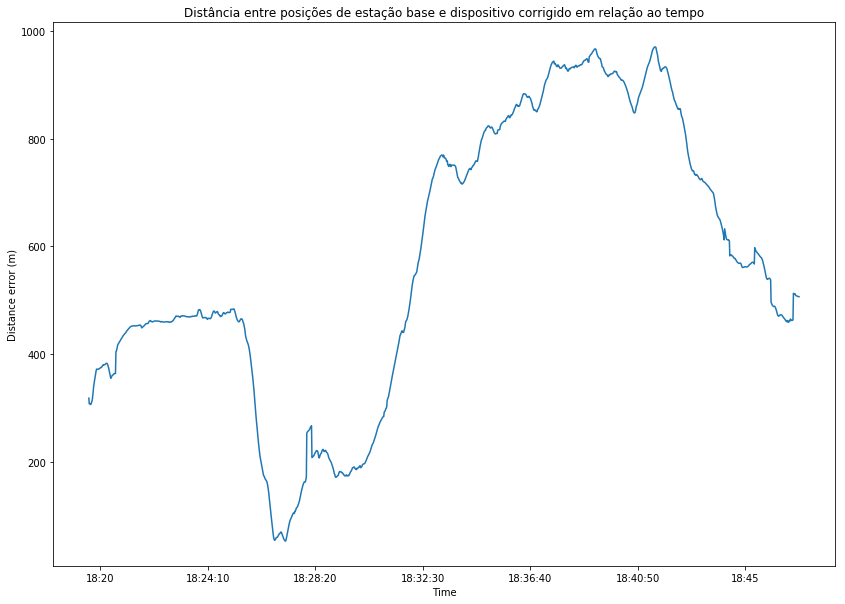

In [33]:
dist = []
wgs84 = nv.FrameE(name='WGS84')
fig = plt.figure(figsize=(14,10)).gca()
for(time, lat_iot, lon_iot, alt_iot, lat_base, lon_base, alt_base) in list(zip(iot_df.index,
                                                                         final['latitude'], 
                                                                         final['longitude'], 
                                                                         final['height'], 
                                                                         pos_df['latitude(deg)'], 
                                                                         pos_df['longitude(deg)'], 
                                                                         pos_df['height(m)'])):
    posA = (lat_base, lon_base)
    posB = (lat_iot, lon_iot)
    dist.append(geodesic(posB, posA).m)
    
fig.plot(iot_df.index, dist)
plt.xlabel("Time")
plt.ylabel("Distance error (m)")
plt.title("Distância entre posições de estação base e dispositivo corrigido em relação ao tempo")
plt.show()

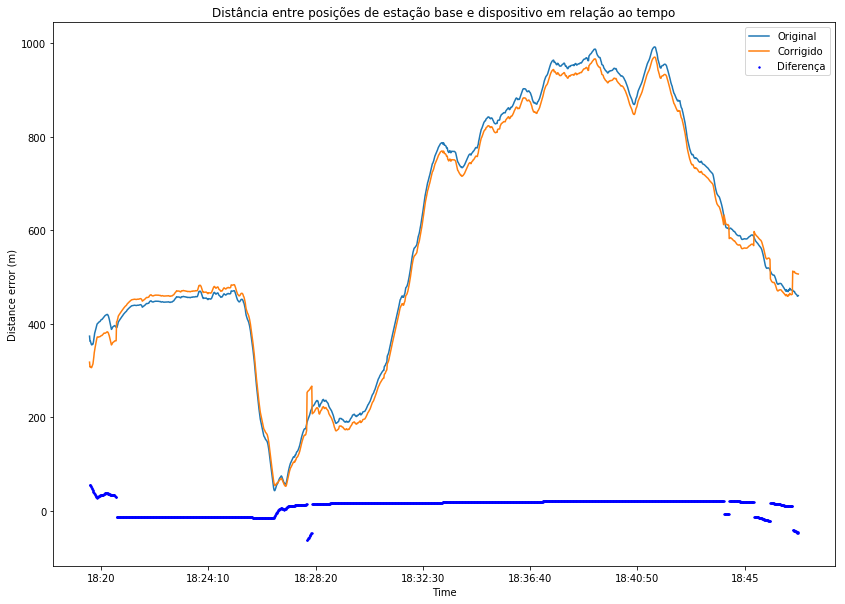

In [34]:
dist_ori = []
wgs84 = nv.FrameE(name='WGS84')
fig = plt.figure(figsize=(14,10)).gca()
for(time, lat_iot, lon_iot, alt_iot, lat_base, lon_base, alt_base) in list(zip(iot_df.index,
                                                                         iot_df['latitude'], 
                                                                         iot_df['longitude'], 
                                                                         iot_df['antenna alt'], 
                                                                         pos_df['latitude(deg)'], 
                                                                         pos_df['longitude(deg)'], 
                                                                         pos_df['height(m)'])):
    posA = (lat_base, lon_base)
    posB = (lat_iot, lon_iot)
    dist_ori.append(geodesic(posB, posA).m)
    
fig.plot(iot_df.index, dist_ori)
plt.xlabel("Time")
plt.ylabel("Distance error (m)")
plt.title("Distância entre posições de estação base e dispositivo em relação ao tempo")

dist = []
wgs84 = nv.FrameE(name='WGS84')
for(time, lat_iot, lon_iot, alt_iot, lat_base, lon_base, alt_base) in list(zip(iot_df.index,
                                                                         final['latitude'], 
                                                                         final['longitude'], 
                                                                         final['height'], 
                                                                         pos_df['latitude(deg)'], 
                                                                         pos_df['longitude(deg)'], 
                                                                         pos_df['height(m)'])):
    posA = (lat_base, lon_base)
    posB = (lat_iot, lon_iot)
    dist.append(geodesic(posB, posA).m)
    
fig.plot(iot_df.index, dist)
for i in range(len(dist)):
    fig.scatter(iot_df.index[i], (dist_ori[i] - dist[i]), color = 'b', s=2)
fig.legend(['Original','Corrigido','Diferença'])
plt.show()

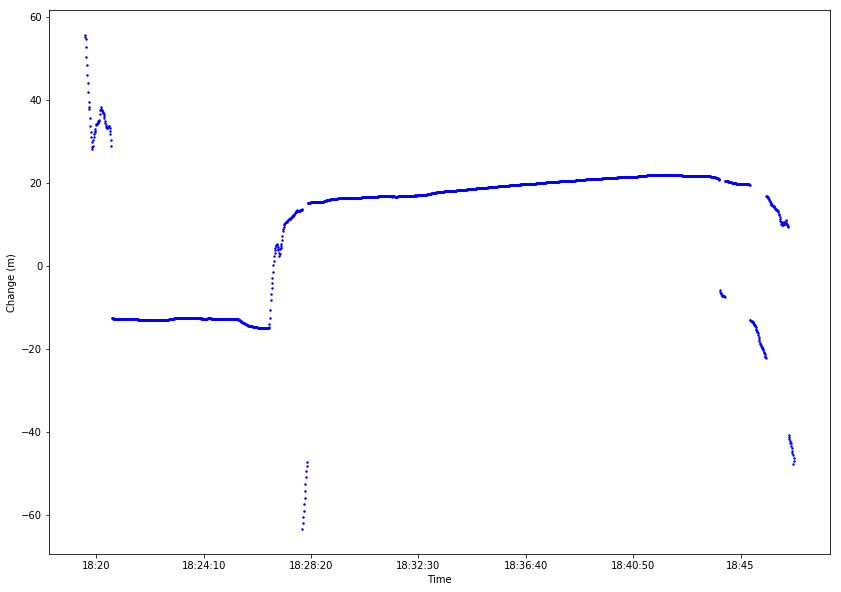

In [35]:
fig = plt.figure(figsize=(14,10)).gca()
for i in range(len(dist)):
    fig.scatter(iot_df.index[i], (dist_ori[i] - dist[i]), color = 'b', s=2)
plt.xlabel("Time")
plt.ylabel("Change (m)")
plt.show()

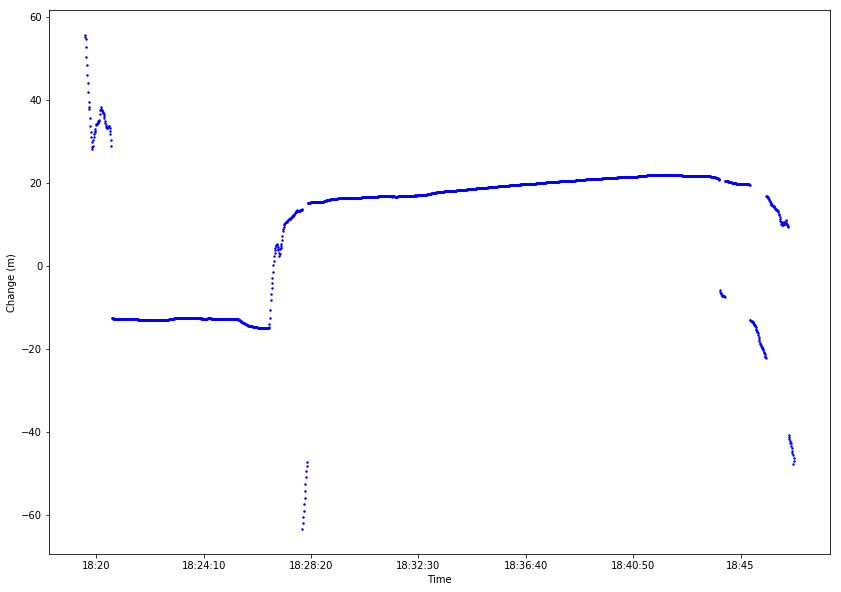

In [36]:
fig = plt.figure(figsize=(14,10)).gca()
for i in range(len(dist)):
    fig.scatter(iot_df.index[i], (dist_ori[i] - dist[i]), color = 'b', s=2)
plt.xlabel("Time")
plt.ylabel("Change (m)")
plt.show()

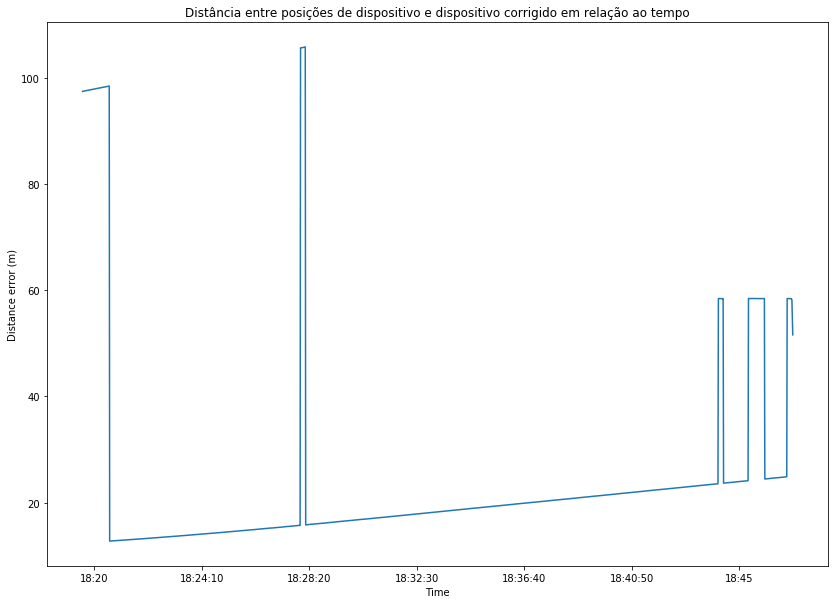

In [37]:
dist = []
wgs84 = nv.FrameE(name='WGS84')
fig = plt.figure(figsize=(14,10)).gca()
for(time, lat_iot, lon_iot, alt_iot, lat_base, lon_base, alt_base) in list(zip(iot_df.index,
                                                                         final['latitude'], 
                                                                         final['longitude'], 
                                                                         final['height'], 
                                                                         iot_df['latitude'], 
                                                                         iot_df['longitude'], 
                                                                         iot_df['antenna alt'])):
    posA = (lat_base, lon_base)
    posB = (lat_iot, lon_iot)
    dist.append(geodesic(posB, posA).m)
    
fig.plot(iot_df.index, dist)
plt.xlabel("Time")
plt.ylabel("Distance error (m)")
plt.title("Distância entre posições de dispositivo e dispositivo corrigido em relação ao tempo")
plt.show()

In [38]:
import simplekml

In [46]:
kml = simplekml.Kml()
for(time, lat_iot, lon_iot, alt_iot, lat_base, lon_base, alt_base) in list(zip(iot_df.index,
                                                                         pos_df['latitude(deg)'], 
                                                                         pos_df['longitude(deg)'], 
                                                                         final['height'], 
                                                                         iot_df['latitude'], 
                                                                         iot_df['longitude'], 
                                                                         iot_df['antenna alt'])):
    pnt = kml.newpoint(name=str(time), coords=[(lon_iot, lat_iot)])
print (kml.kml())

<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2">
    <Document id="6619">
        <Placemark id="6621">
            <name>18:19:33</name>
            <Point id="6620">
                <coordinates>-47.872176478,-15.765921109,0.0</coordinates>
            </Point>
        </Placemark>
        <Placemark id="6623">
            <name>18:19:34</name>
            <Point id="6622">
                <coordinates>-47.872177855,-15.765921897,0.0</coordinates>
            </Point>
        </Placemark>
        <Placemark id="6625">
            <name>18:19:35</name>
            <Point id="6624">
                <coordinates>-47.872177271000005,-15.765923951,0.0</coordinates>
            </Point>
        </Placemark>
        <Placemark id="6627">
            <name>18:19:36</name>
            <Point id="6626">
                <coordinates>-47.872177742,-15.765926057,0.0</coordinates>
            </Point>
        </Placema

In [47]:
f = open("pos.kml","w+")
f.write(kml.kml())
f.close()